In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    top_k_accuracy_score
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# ===============================================================
# Load Historical Data
# ===============================================================
players = pd.read_csv("data/players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
awards = pd.read_csv("data/awards_players.csv")
teams = pd.read_csv("data/teams.csv")
teams_post = pd.read_csv("data/teams_post.csv")

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Players: {players.shape}")
print(f"Player-Team records: {players_teams.shape}")
print(f"Awards: {awards.shape}")
print(f"Teams: {teams.shape}")
print(f"Playoff teams: {teams_post.shape}")

# Identify available years
min_year = players_teams['year'].min()
max_year = players_teams['year'].max()
total_years = max_year - min_year + 1

print(f"\nData spans years {min_year} to {max_year} ({total_years} years)")

DATASET OVERVIEW
Players: (893, 10)
Player-Team records: (1876, 43)
Awards: (95, 4)
Teams: (142, 61)
Playoff teams: (80, 5)

Data spans years 1 to 10 (10 years)


In [3]:
# ===============================================================
# Define Target Awards
# ===============================================================
main_awards = [
    'Most Valuable Player',
    'Defensive Player of the Year',
    'Most Improved Player',
    'WNBA Finals Most Valuable Player',
    'Rookie of the Year',
    'All-Star Game Most Valuable Player'
]

# Coach award is separate (different entity type)
coach_award = 'Coach of the Year'

print("="*70)
print("AWARD DISTRIBUTION")
print("="*70)

awards_main = awards[awards['award'].isin(main_awards)].copy()
awards_coach = awards[awards['award'] == coach_award].copy()

for award in main_awards:
    count = len(awards_main[awards_main['award'] == award])
    years_with_award = awards_main[awards_main['award'] == award]['year'].nunique()
    print(f"\n{award}:")
    print(f"  Total winners: {count}")
    print(f"  Years with award: {years_with_award}")

print(f"\n{coach_award}:")
print(f"  Total winners: {len(awards_coach)}")
print(f"  Years with award: {awards_coach['year'].nunique()}")

print(f"\n" + "="*70)
print("WHY THESE SEVEN AWARDS?")
print("="*70)
print("""
PREDICTABLE with historical data (T-1):
   • MVP: Team success + individual excellence
   • DPOY: Defensive stats + team context
   • FMVP: Playoff performance from previous year
   • MIP: Statistical improvement (though highly subjective)
   • COTY: Team improvement + coach track record
   • ASG_MVP: All-Star Game MVP - Single game in exhibition setting

PREDICTABLE with biometric/context data (low accuracy expected):
   • ROY: Uses rookie biometrics (height, weight), college, team coach
         No T-1 stats exist for rookies, but pre-season data can help
   
NOT PREDICTABLE - Excluded Awards:

   • Sixth Woman of the Year (3 winners):
     - 2/3 winners were rookies (no T-1 stats)
     - Award requires coming off the bench - role-based, not just stats

   • Kim Perrot Sportsmanship Award (10 winners):
     - Purely subjective - based on character, not statistics
     - No measurable metrics in data (no "sportsmanship" column)
     - Voted by players based on personal interactions

   • WNBA All-Decade Team / Honorable Mention (15 total):
     - Retrospective career achievement award, not annual
     - Given once per decade based on entire career
     - Cannot predict with single-year T-1 features

MIP LIMITATION:
   Analysis later shows MIP is often NOT awarded to the most statistically improved player.
   Some winners ranked 50th-80th in improvement metrics. Award appears driven by
   narrative, media coverage, and subjective factors beyond pure statistics.
   Model will predict based on improvement, but low accuracy is expected.

ROY LIMITATION:
   ROY prediction uses only pre-season data: biometrics, college reputation, and coach.
   Without actual game performance, accuracy will be limited. This explores whether
   draft context alone can predict rookie success.
""")

total_player_seasons = len(players_teams)
print(f"\nClass Imbalance:")
print(f"   Total player-season records: {total_player_seasons}")
for award in main_awards:
    count = len(awards_main[awards_main['award'] == award])
    ratio = count / total_player_seasons * 100
    print(f"   {award}: {count} / {total_player_seasons} ({ratio:.3f}%)")
print(f"\n   Highly imbalanced - will use class_weight='balanced' in models")

AWARD DISTRIBUTION

Most Valuable Player:
  Total winners: 10
  Years with award: 10

Defensive Player of the Year:
  Total winners: 10
  Years with award: 10

Most Improved Player:
  Total winners: 9
  Years with award: 8

WNBA Finals Most Valuable Player:
  Total winners: 10
  Years with award: 10

Rookie of the Year:
  Total winners: 10
  Years with award: 10

All-Star Game Most Valuable Player:
  Total winners: 8
  Years with award: 8

Coach of the Year:
  Total winners: 10
  Years with award: 10

WHY THESE SEVEN AWARDS?

PREDICTABLE with historical data (T-1):
   • MVP: Team success + individual excellence
   • DPOY: Defensive stats + team context
   • FMVP: Playoff performance from previous year
   • MIP: Statistical improvement (though highly subjective)
   • COTY: Team improvement + coach track record
   • ASG_MVP: All-Star Game MVP - Single game in exhibition setting

PREDICTABLE with biometric/context data (low accuracy expected):
   • ROY: Uses rookie biometrics (height, wei

### Feature Categories:
1. **Player Performance**: Points, rebounds, assists, efficiency, player rating
2. **Comparison to League Average**: How player performs vs league norms
3. **Team Success Context**: Win percentage, playoff performance, championship
4. **Career History**: Years of experience, past awards
5. **Improvement Trajectory**: Year-over-year improvement (T-1 vs T-2)
6. **Playoff Performance**: Postseason statistics for FMVP prediction

In [4]:
# ===============================================================
# Calculate Player Performance Statistics
# ===============================================================
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

player_stats = players_teams.copy()

# filter: minimum 10 games played to ensure meaningful statistics
player_stats = player_stats[player_stats['GP'] >= 10]
print(f"\nPlayer-seasons with GP >= 10: {len(player_stats)}")

# per-game statistics (normalized by games played)
player_stats['ppg'] = player_stats['points'] / player_stats['GP']
player_stats['rpg'] = player_stats['rebounds'] / player_stats['GP']
player_stats['apg'] = player_stats['assists'] / player_stats['GP']
player_stats['spg'] = player_stats['steals'] / player_stats['GP']
player_stats['bpg'] = player_stats['blocks'] / player_stats['GP']
player_stats['mpg'] = player_stats['minutes'] / player_stats['GP']
player_stats['topg'] = player_stats['turnovers'] / player_stats['GP']

# defensive-specific stats
player_stats['drpg'] = player_stats['dRebounds'] / player_stats['GP']  # defensive rebounds per game
player_stats['def_rating'] = (player_stats['steals'] * 2 + player_stats['blocks'] * 3 + player_stats['dRebounds']) / player_stats['GP']

# shooting efficiency
player_stats['fg_pct'] = np.where(
    player_stats['fgAttempted'] > 0, 
    player_stats['fgMade'] / player_stats['fgAttempted'], 
    0
)
player_stats['ft_pct'] = np.where(
    player_stats['ftAttempted'] > 0,
    player_stats['ftMade'] / player_stats['ftAttempted'],
    0
)

# efficiency rating (basketball reference formula simplified)
player_stats['efficiency'] = (
    player_stats['points'] + 
    player_stats['rebounds'] + 
    player_stats['assists'] + 
    player_stats['steals'] + 
    player_stats['blocks'] - 
    player_stats['turnovers']
) / player_stats['GP']

# custom player rating (weighted contribution per 36 minutes)
player_stats['player_rating'] = (
    player_stats['points'] +
    player_stats['rebounds'] * 1.2 +
    player_stats['assists'] * 1.5 +
    player_stats['steals'] * 3.0 +
    player_stats['blocks'] * 3.0 -
    player_stats['turnovers'] * 2.0 -
    player_stats['PF'] * 0.5
) / (player_stats['minutes'] / 36 + 1)

print("Player statistics calculated")

player_stats['gs_pct'] = player_stats['GS'] / player_stats['GP']
# starting percentage

FEATURE ENGINEERING

Player-seasons with GP >= 10: 1603
Player statistics calculated


In [5]:
# ===============================================================
# Calculate League Averages by Year
# ===============================================================
yearly_avg = player_stats.groupby('year').agg({
    'ppg': 'mean', 
    'rpg': 'mean', 
    'apg': 'mean', 
    'spg': 'mean', 
    'bpg': 'mean',
    'efficiency': 'mean', 
    'mpg': 'mean', 
    'player_rating': 'mean'
}).reset_index()

yearly_avg.columns = [
    'year', 'league_ppg', 'league_rpg', 'league_apg', 'league_spg', 
    'league_bpg', 'league_efficiency', 'league_mpg', 'league_player_rating'
]

# elite player cutoff (top 10% by player rating)
elite_cutoffs = player_stats.groupby('year')['player_rating'].quantile(0.90).reset_index()
elite_cutoffs.columns = ['year', 'elite_cutoff']

# merge back to player stats
player_stats = player_stats.merge(yearly_avg, on='year', how='left')
player_stats = player_stats.merge(elite_cutoffs, on='year', how='left')
player_stats['is_elite'] = (player_stats['player_rating'] >= player_stats['elite_cutoff']).astype(int)

print(f"League averages calculated for {len(yearly_avg)} years")
print(f"   Elite players identified (top 10% each year)")

League averages calculated for 10 years
   Elite players identified (top 10% each year)


In [6]:
# ===============================================================
# Calculate Team Success Metrics
# ===============================================================
teams_success = teams[['year', 'tmID', 'won', 'lost', 'confID', 'playoff', 'o_pts', 'd_pts', 'GP']].copy()

# win percentage
teams_success['win_pct'] = teams_success['won'] / (teams_success['won'] + teams_success['lost'])

# conference ranking
teams_success['conf_rank'] = teams_success.groupby(['year', 'confID'])['win_pct'].rank(ascending=False)

# playoff indicator
teams_success['made_playoffs'] = teams_success['playoff'].notna().astype(int)

# point differential per game
teams_success['margin_per_game'] = (teams_success['o_pts'] - teams_success['d_pts']) / teams_success['GP']

# championship indicator
playoff_wins = teams_post.groupby(['year', 'tmID'])['W'].sum().reset_index()
champion_idx = playoff_wins.groupby('year')['W'].idxmax()
champions = playoff_wins.loc[champion_idx][['year', 'tmID']].copy()
champions['won_championship'] = 1

teams_success = teams_success.merge(champions, on=['year', 'tmID'], how='left')
teams_success['won_championship'] = teams_success['won_championship'].fillna(0).astype(int)

# total playoff wins
playoff_stats = teams_post.groupby(['year', 'tmID']).agg({'W': 'sum'}).reset_index()
playoff_stats.columns = ['year', 'tmID', 'playoff_wins']
teams_success = teams_success.merge(playoff_stats, on=['year', 'tmID'], how='left')
teams_success['playoff_wins'] = teams_success['playoff_wins'].fillna(0).astype(int)

print(f"Team success metrics calculated")
print(f"   Championships per year: {champions.groupby('year').size().mean():.1f}")

Team success metrics calculated
   Championships per year: 1.0


In [7]:
# ===============================================================
# Build Training Dataset with T-1 Features
# ===============================================================

def build_award_dataset(start_year, end_year):
    records = []
    years = range(start_year, end_year + 1)
    
    print(f"\nBuilding dataset for years {start_year}-{end_year}")
    print(f"Using T-1 features from years {start_year-1}-{end_year-1}")
    
    for target_year in years:
        prev_year = target_year - 1
        
        # get target year roster
        target_roster = players_teams[players_teams['year'] == target_year][['playerID', 'tmID']].drop_duplicates()
        
        # get previous year stats (T-1)
        prev_year_stats = player_stats[player_stats['year'] == prev_year].copy()
        prev_year_teams = teams_success[teams_success['year'] == prev_year].copy()
        
        # get target year awards
        target_year_awards = awards_main[awards_main['year'] == target_year].copy()
        
        # for each player in target year roster
        for _, roster_row in target_roster.iterrows():
            player_id = roster_row['playerID']
            tm_id = roster_row['tmID']
            
            # get their T-1 stats (if they played in T-1)
            player_prev_stats = prev_year_stats[prev_year_stats['playerID'] == player_id]
            
            if len(player_prev_stats) == 0:
                # player is a rookie or didn't play in T-1 (skip for now)
                continue
            
            player_row = player_prev_stats.iloc[0]
            player_id = player_row['playerID']
            tm_id = player_row['tmID']
            
            team_row = prev_year_teams[prev_year_teams['tmID'] == tm_id]
            
            record = {
                'playerID': player_id,
                'tmID': tm_id,
                'target_year': target_year,
                'prev_year': prev_year,
                
                # T-1 player stats
                'ppg_prev': player_row['ppg'],
                'rpg_prev': player_row['rpg'],
                'apg_prev': player_row['apg'],
                'spg_prev': player_row['spg'],
                'bpg_prev': player_row['bpg'],
                'mpg_prev': player_row['mpg'],
                'topg_prev': player_row['topg'],
                'fg_pct_prev': player_row['fg_pct'],
                'ft_pct_prev': player_row['ft_pct'],
                'efficiency_prev': player_row['efficiency'],
                'player_rating_prev': player_row['player_rating'],
                'is_elite_prev': player_row['is_elite'],
                'GP_prev': player_row['GP'],
                'GS_prev': player_row['GS'],
                'gs_pct_prev': player_row['gs_pct'],
                'minutes_prev': player_row['minutes'],
                
                # defensive-specific stats
                'drpg_prev': player_row['drpg'],
                'def_rating_prev': player_row['def_rating'],
                
                # comparison to league average
                'ppg_vs_league': player_row['ppg'] - player_row['league_ppg'],
                'rpg_vs_league': player_row['rpg'] - player_row['league_rpg'],
                'apg_vs_league': player_row['apg'] - player_row['league_apg'],
                'efficiency_vs_league': player_row['efficiency'] - player_row['league_efficiency'],
                'rating_vs_league': player_row['player_rating'] - player_row['league_player_rating'],
            }
            
            # team context from T-1
            if len(team_row) > 0:
                team_row = team_row.iloc[0]
                record['win_pct_prev'] = team_row['win_pct']
                record['conf_rank_prev'] = team_row['conf_rank']
                record['made_playoffs_prev'] = team_row['made_playoffs']
                record['margin_prev'] = team_row['margin_per_game']
                record['won_championship_prev'] = team_row['won_championship']
                record['playoff_wins_prev'] = team_row['playoff_wins']
            else:
                # fallback for missing team data
                record['win_pct_prev'] = 0.5
                record['conf_rank_prev'] = 6
                record['made_playoffs_prev'] = 0
                record['margin_prev'] = 0
                record['won_championship_prev'] = 0
                record['playoff_wins_prev'] = 0
            
            # award targets (what we're predicting)
            for award in main_awards:
                col_name = f"won_{award.replace(' ', '_').lower()}"
                won = len(target_year_awards[
                    (target_year_awards['playerID'] == player_id) & 
                    (target_year_awards['award'] == award)
                ]) > 0
                record[col_name] = int(won)
            
            records.append(record)
    
    df = pd.DataFrame(records)
    print(f"Dataset built: {df.shape}")
    return df

print("Dataset building function defined")

Dataset building function defined


In [8]:
# ===============================================================
# Add Career Features
# ===============================================================

def add_career_features(df):
    
    # years of experience
    player_first_year = player_stats.groupby('playerID')['year'].min().reset_index()
    player_first_year.columns = ['playerID', 'first_year']
    df = df.merge(player_first_year, on='playerID', how='left')
    df['years_experience'] = df['prev_year'] - df['first_year']
    df['years_experience'] = df['years_experience'].fillna(0)
    
    # career awards
    for award in main_awards:
        award_col = f"career_{award.replace(' ', '_').lower()}"
        df[award_col] = 0
    df['career_total_awards'] = 0
    
    for idx, row in df.iterrows():
        player_id = row['playerID']
        target_year = row['target_year']
        
        past_awards = awards_main[
            (awards_main['playerID'] == player_id) & 
            (awards_main['year'] < target_year)
        ]
        
        total = 0
        for award in main_awards:
            award_col = f"career_{award.replace(' ', '_').lower()}"
            count = len(past_awards[past_awards['award'] == award])
            df.at[idx, award_col] = count
            total += count
        df.at[idx, 'career_total_awards'] = total
    
    print(f"Career features added")
    return df

def add_improvement_features(df):
    player_stats_sorted = player_stats.sort_values(['playerID', 'year'])
    player_stats_sorted['ppg_prev2'] = player_stats_sorted.groupby('playerID')['ppg'].shift(1)
    player_stats_sorted['efficiency_prev2'] = player_stats_sorted.groupby('playerID')['efficiency'].shift(1)
    player_stats_sorted['player_rating_prev2'] = player_stats_sorted.groupby('playerID')['player_rating'].shift(1)
    player_stats_sorted['mpg_prev2'] = player_stats_sorted.groupby('playerID')['mpg'].shift(1)
    
    prev2_cols = ['playerID', 'year', 'ppg_prev2', 'efficiency_prev2', 'player_rating_prev2', 'mpg_prev2']
    prev2_data = player_stats_sorted[prev2_cols].copy()
    prev2_data = prev2_data.rename(columns={'year': 'prev_year'})
    
    df = df.merge(prev2_data, on=['playerID', 'prev_year'], how='left')
    
    # calculate improvement (T-1 vs T-2)
    df['ppg_improvement'] = df['ppg_prev'] - df['ppg_prev2'].fillna(df['ppg_prev'])
    df['efficiency_improvement'] = df['efficiency_prev'] - df['efficiency_prev2'].fillna(df['efficiency_prev'])
    df['rating_improvement'] = df['player_rating_prev'] - df['player_rating_prev2'].fillna(df['player_rating_prev'])
    df['mpg_improvement'] = df['mpg_prev'] - df['mpg_prev2'].fillna(df['mpg_prev'])
    
    print(f"Improvement features added")
    return df

# add playoff features
def add_playoff_features(df):
    playoff_cols = ['playerID', 'year', 'tmID', 'PostGP', 'PostGS', 'PostMinutes', 
                   'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks']
    
    existing_cols = [c for c in playoff_cols if c in players_teams.columns]
    playoff_data = players_teams[existing_cols].copy()
    playoff_data = playoff_data.rename(columns={'year': 'prev_year'})
    
    rename_dict = {c: f"{c}_prev" for c in existing_cols if c not in ['playerID', 'prev_year', 'tmID']}
    playoff_data = playoff_data.rename(columns=rename_dict)
    
    df = df.merge(playoff_data, on=['playerID', 'prev_year', 'tmID'], how='left')
    
    # fill missing playoff data with 0
    for col in df.columns:
        if 'Post' in col:
            df[col] = df[col].fillna(0)
    
    # calculate per-game playoff stats
    if 'PostGP_prev' in df.columns and 'PostPoints_prev' in df.columns:
        df['playoff_ppg_prev'] = np.where(
            df['PostGP_prev'] > 0,
            df['PostPoints_prev'] / df['PostGP_prev'],
            0
        )
    
    print(f"Playoff features added")
    return df

# ===============================================================
# Build ROY Dataset (needs special function)
# ===============================================================

def build_roy_dataset(start_year, end_year):
    """
    Build dataset for Rookie of the Year prediction.
    Uses biometric data (height, weight), college, and team coach.
    Only includes players in their first season (rookies).
    """
    records = []
    years = range(start_year, end_year + 1)
    
    print(f"\nBuilding ROY dataset for years {start_year}-{end_year}")
    print(f"Using biometrics, college, and coach data for rookies")
    
    # get coaches data
    coaches = pd.read_csv("data/coaches.csv")
    
    # get first year for each player to identify rookies
    player_first_year = players_teams.groupby('playerID')['year'].min().reset_index()
    player_first_year.columns = ['playerID', 'first_year']
    
    for target_year in years:
        # calculate college scores
        past_roy_winners = awards[(awards['award'] == 'Rookie of the Year') & (awards['year'] < target_year)]['playerID'].tolist()
        past_roy_colleges = players[players['bioID'].isin(past_roy_winners)]['college'].value_counts()
        
        # create college reputation score
        all_colleges = players['college'].unique()
        college_scores = {}
        for college in all_colleges:
            if college in past_roy_colleges.index:
                college_scores[college] = past_roy_colleges[college] + 1  # bonus for past ROY winners
            elif college and college != 'none' and college != '':
                college_scores[college] = 1  # base score for known colleges
            else:
                college_scores[college] = 0  # unknown/no college
        
        # calculate coach history
        coaches_before_target = coaches[coaches['year'] < target_year]
        coach_history = coaches_before_target.groupby('coachID').agg({
            'won': 'sum',
            'lost': 'sum',
            'post_wins': 'sum',
            'post_losses': 'sum'
        }).reset_index()
        coach_history['coach_career_win_pct'] = coach_history['won'] / (coach_history['won'] + coach_history['lost'] + 0.001)
        coach_history['coach_career_playoff_wins'] = coach_history['post_wins']
        
        # get target year roster
        target_roster = players_teams[players_teams['year'] == target_year][['playerID', 'tmID']].drop_duplicates()
        
        # identify rookies (players in their first year)
        target_roster = target_roster.merge(player_first_year, on='playerID', how='left')
        rookies = target_roster[target_roster['first_year'] == target_year].copy()
        
        if len(rookies) == 0:
            continue
        
        # get target year awards
        target_year_awards = awards_main[awards_main['year'] == target_year].copy()
        
        # get team data from previous year
        prev_year_teams = teams_success[teams_success['year'] == target_year - 1].copy()
        
        # get coach for each team in target year
        target_coaches = coaches[coaches['year'] == target_year][['tmID', 'coachID']].drop_duplicates()
        
        for _, rookie_row in rookies.iterrows():
            player_id = rookie_row['playerID']
            tm_id = rookie_row['tmID']
            
            # get player biometric data
            player_bio = players[players['bioID'] == player_id]
            
            if len(player_bio) == 0:
                continue
            
            player_bio = player_bio.iloc[0]
            
            # get position encoding
            pos = str(player_bio['pos']) if pd.notna(player_bio['pos']) else ''
            is_guard = 1 if 'G' in pos else 0
            is_forward = 1 if 'F' in pos else 0
            is_center = 1 if 'C' in pos else 0
            
            # get college info
            college = player_bio['college'] if pd.notna(player_bio['college']) else ''
            college_score = college_scores.get(college, 0)
            has_college = 1 if college and college != 'none' and college != '' else 0
            
            # get coach info
            team_coach = target_coaches[target_coaches['tmID'] == tm_id]
            if len(team_coach) > 0:
                coach_id = team_coach.iloc[0]['coachID']
                coach_stats = coach_history[coach_history['coachID'] == coach_id]
                if len(coach_stats) > 0:
                    coach_win_pct = coach_stats.iloc[0]['coach_career_win_pct']
                    coach_playoff_wins = coach_stats.iloc[0]['coach_career_playoff_wins']
                else:
                    coach_win_pct = 0.5
                    coach_playoff_wins = 0
            else:
                coach_win_pct = 0.5
                coach_playoff_wins = 0
            
            # get team context from previous year
            team_row = prev_year_teams[prev_year_teams['tmID'] == tm_id]
            if len(team_row) > 0:
                team_row = team_row.iloc[0]
                team_win_pct = team_row['win_pct']
                team_conf_rank = team_row['conf_rank']
                team_made_playoffs = team_row['made_playoffs']
            else:
                team_win_pct = 0.5
                team_conf_rank = 6
                team_made_playoffs = 0
            
            record = {
                'playerID': player_id,
                'tmID': tm_id,
                'target_year': target_year,
                
                # biometric features
                'height': player_bio['height'] if pd.notna(player_bio['height']) else 70,
                'weight': player_bio['weight'] if pd.notna(player_bio['weight']) else 160,
                
                # position
                'is_guard': is_guard,
                'is_forward': is_forward,
                'is_center': is_center,
                
                # college features
                'college_score': college_score,
                'has_college': has_college,
                
                # coach features (historical, before target year)
                'coach_win_pct': coach_win_pct,
                'coach_playoff_wins': coach_playoff_wins,
                
                # team context (from previous year - pre-season info)
                'team_win_pct': team_win_pct,
                'team_conf_rank': team_conf_rank,
                'team_made_playoffs': team_made_playoffs,
                
                # target
                'won_rookie_of_the_year': int(len(target_year_awards[
                    (target_year_awards['playerID'] == player_id) & 
                    (target_year_awards['award'] == 'Rookie of the Year')
                ]) > 0)
            }
            
            records.append(record)
    
    df = pd.DataFrame(records)
    print(f"ROY Dataset built: {df.shape} (rookies only)")
    return df

# ===============================================================
# Build COTY Dataset (Coach of the Year)
# ===============================================================

def build_coty_dataset(start_year, end_year):
    """
    Build dataset for Coach of the Year prediction using T-1 data.
    Uses previous year team performance + coach career history.
    NO current season data to avoid data leakage.
    """
    records = []
    years = range(start_year, end_year + 1)
    
    print(f"\nBuilding COTY dataset for years {start_year}-{end_year}")
    
    # Load coaches data
    coaches = pd.read_csv("data/coaches.csv")
    
    for target_year in years:
        prev_year = target_year - 1
        
        # Get coaches for target year (to know who is coaching which team)
        year_coaches = coaches[coaches['year'] == target_year].copy()
        
        if len(year_coaches) == 0:
            continue
        
        # Get T-1 team records (what we can see before the season)
        prev_year_teams = teams_success[teams_success['year'] == prev_year].copy()
        
        # Get T-2 team records for improvement calculation
        prev2_year_teams = teams_success[teams_success['year'] == prev_year - 1].copy()
        
        # Calculate coach career history using ONLY years BEFORE target_year
        coaches_before_target = coaches[coaches['year'] < target_year]
        coach_career = coaches_before_target.groupby('coachID').agg({
            'won': 'sum',
            'lost': 'sum',
            'post_wins': 'sum',
            'year': 'nunique'  # years of experience
        }).reset_index()
        coach_career.columns = ['coachID', 'career_wins', 'career_losses', 'career_playoff_wins', 'years_coaching']
        coach_career['career_win_pct'] = coach_career['career_wins'] / (coach_career['career_wins'] + coach_career['career_losses'] + 0.001)
        
        # Check if coach won COTY before
        past_coty = awards_coach[awards_coach['year'] < target_year]['playerID'].tolist()
        
        # Get COTY winner for this year
        coty_winner = awards_coach[awards_coach['year'] == target_year]
        coty_winner_id = coty_winner['playerID'].values[0] if len(coty_winner) > 0 else None
        
        for _, coach_row in year_coaches.iterrows():
            coach_id = coach_row['coachID']
            tm_id = coach_row['tmID']
            
            # T-1 team performance (previous season results)
            prev_team = prev_year_teams[prev_year_teams['tmID'] == tm_id]
            if len(prev_team) > 0:
                prev_team = prev_team.iloc[0]
                wins_prev = prev_team['won'] if 'won' in prev_team else 0
                win_pct_prev = prev_team['win_pct']
                conf_rank_prev = prev_team['conf_rank']
                made_playoffs_prev = prev_team['made_playoffs']
                playoff_wins_prev = prev_team['playoff_wins']
                margin_prev = prev_team['margin_per_game']
            else:
                wins_prev = 0
                win_pct_prev = 0.5
                conf_rank_prev = 6
                made_playoffs_prev = 0
                playoff_wins_prev = 0
                margin_prev = 0
            
            # T-1 vs T-2 improvement (team trajectory before season starts)
            prev2_team = prev2_year_teams[prev2_year_teams['tmID'] == tm_id]
            if len(prev2_team) > 0:
                prev2_team = prev2_team.iloc[0]
                prev2_win_pct = prev2_team['win_pct']
                prev2_made_playoffs = prev2_team['made_playoffs']
                win_improvement_prev = win_pct_prev - prev2_win_pct
                playoff_improvement_prev = made_playoffs_prev - prev2_made_playoffs
            else:
                win_improvement_prev = 0
                playoff_improvement_prev = 0
            
            # Coach career history
            coach_hist = coach_career[coach_career['coachID'] == coach_id]
            if len(coach_hist) > 0:
                career_win_pct = coach_hist.iloc[0]['career_win_pct']
                career_playoff_wins = coach_hist.iloc[0]['career_playoff_wins']
                years_coaching = coach_hist.iloc[0]['years_coaching']
            else:
                career_win_pct = 0.5
                career_playoff_wins = 0
                years_coaching = 0
            
            # Has won COTY before
            won_coty_before = 1 if coach_id in past_coty else 0
            
            record = {
                'coachID': coach_id,
                'tmID': tm_id,
                'target_year': target_year,
                
                # T-1 team performance (previous season)
                'wins_prev': wins_prev,
                'win_pct_prev': win_pct_prev,
                'conf_rank_prev': conf_rank_prev,
                'made_playoffs_prev': made_playoffs_prev,
                'playoff_wins_prev': playoff_wins_prev,
                'margin_prev': margin_prev,
                
                # Team trajectory (T-1 vs T-2)
                'win_improvement_prev': win_improvement_prev,
                'playoff_improvement_prev': playoff_improvement_prev,
                
                # Coach career history (before target year)
                'career_win_pct': career_win_pct,
                'career_playoff_wins': career_playoff_wins,
                'years_coaching': years_coaching,
                'won_coty_before': won_coty_before,
                
                # Target
                'won_coach_of_the_year': int(coach_id == coty_winner_id)
            }
            
            records.append(record)
    
    df = pd.DataFrame(records)
    print(f"COTY Dataset built: {df.shape}")
    return df

print("Feature engineering functions defined")

Feature engineering functions defined


In [9]:
# ===============================================================
# Define Feature Sets for Each Award
# ===============================================================

# MVP: Overall excellence + team success
features_mvp = [
    # performance
    'ppg_prev', 'rpg_prev', 'apg_prev', 'spg_prev', 'bpg_prev', 'mpg_prev',
    'fg_pct_prev', 'efficiency_prev', 'player_rating_prev', 'gs_pct_prev',
    'GP_prev', 'minutes_prev',
    # vs League
    'ppg_vs_league', 'rpg_vs_league', 'apg_vs_league', 
    'efficiency_vs_league', 'rating_vs_league',
    'is_elite_prev',
    # team success (MVP usually on winning team)
    'win_pct_prev', 'conf_rank_prev', 'made_playoffs_prev', 'margin_prev',
    # career
    'years_experience', 'career_total_awards', 'career_most_valuable_player'
]

# DPOY: Defensive stats + team context + career history
features_dpoy = [
    # defensive stats
    'spg_prev', 'bpg_prev', 'drpg_prev', 'def_rating_prev',
    # overall performance context
    'rpg_prev', 'mpg_prev', 'GP_prev', 'gs_pct_prev',
    'efficiency_prev', 'player_rating_prev',
    # team success (good defenders often on good teams)
    'win_pct_prev', 'made_playoffs_prev',
    # career history
    'years_experience', 
    'career_total_awards', 'career_defensive_player_of_the_year',
]

# MIP: Improvement trajectory
features_mip = [
    # current performance level
    'ppg_prev', 'efficiency_prev', 'player_rating_prev', 'mpg_prev',
    'GP_prev', 'gs_pct_prev',
    # improvement metrics
    'ppg_improvement', 'efficiency_improvement', 'rating_improvement', 'mpg_improvement',
    # vs league average
    'ppg_vs_league', 'efficiency_vs_league',
    # team context
    'win_pct_prev',
    # career
    'years_experience',
    'career_total_awards'
]

# FMVP: Playoff performance + championship
features_fmvp = [
    # playoff stats
    'PostPoints_prev', 'PostRebounds_prev', 'PostAssists_prev', 
    'PostSteals_prev', 'PostBlocks_prev',
    'PostGP_prev', 'PostGS_prev', 'PostMinutes_prev',
    'playoff_ppg_prev',
    # regular season performance
    'player_rating_prev', 'efficiency_prev',
    'ppg_prev', 'rpg_prev', 'apg_prev',
    # team playoff success
    'won_championship_prev', 'playoff_wins_prev',
    # career
    'years_experience',
    'career_total_awards', 'career_wnba_finals_most_valuable_player'
]

# ROY: Biometrics, college reputation, coach success (no T-1 stats for rookies)
features_roy = [
    # biometrics
    'height', 'weight',
    # position
    'is_guard', 'is_forward', 'is_center',
    # college reputation
    'college_score', 'has_college',
    # coach track record
    'coach_win_pct', 'coach_playoff_wins',
    # team context
    'team_win_pct', 'team_conf_rank', 'team_made_playoffs'
]

# COTY: Coach of the Year
features_coty = [
    # T-1 team performance (previous season results)
    'wins_prev', 'win_pct_prev', 'conf_rank_prev', 'made_playoffs_prev', 'playoff_wins_prev', 'margin_prev',
    # team trajectory (T-1 vs T-2)
    'win_improvement_prev', 'playoff_improvement_prev',
    # career history
    'career_win_pct', 'career_playoff_wins', 'years_coaching', 'won_coty_before'
]

# ASG_MVP: All-Star Game MVP - elite players + star power
features_asg_mvp = [
    # performance (star players tend to win)
    'ppg_prev', 'rpg_prev', 'apg_prev', 'spg_prev', 'bpg_prev', 'mpg_prev',
    'fg_pct_prev', 'efficiency_prev', 'player_rating_prev', 'gs_pct_prev',
    'GP_prev', 'minutes_prev',
    # vs League (All-Stars are elite by definition)
    'ppg_vs_league', 'rpg_vs_league', 'apg_vs_league',
    'efficiency_vs_league', 'rating_vs_league',
    'is_elite_prev',
    # team success context
    'win_pct_prev', 'conf_rank_prev', 'made_playoffs_prev',
    # career (star power / name recognition)
    'years_experience', 'career_total_awards', 'career_most_valuable_player'
]

award_configs = {
    'MVP': {
        'target': 'won_most_valuable_player',
        'features': features_mvp,
        'filter': None,
        'uses_roy_data': False,
        'uses_coty_data': False
    },
    'DPOY': {
        'target': 'won_defensive_player_of_the_year',
        'features': features_dpoy,
        'filter': None,
        'uses_roy_data': False,
        'uses_coty_data': False
    },
    'MIP': {
        'target': 'won_most_improved_player',
        'features': features_mip,
        'filter': lambda df: df['years_experience'] >= 0,
        'uses_roy_data': False,
        'uses_coty_data': False
    },
    'FMVP': {
        'target': 'won_wnba_finals_most_valuable_player',
        'features': features_fmvp,
        'filter': lambda df: (df['made_playoffs_prev'] == 1) & (df['PostGP_prev'] > 0),
        'uses_roy_data': False,
        'uses_coty_data': False
    },
    'ROY': {
        'target': 'won_rookie_of_the_year',
        'features': features_roy,
        'filter': None,
        'uses_roy_data': True,
        'uses_coty_data': False
    },
    'COTY': {
        'target': 'won_coach_of_the_year',
        'features': features_coty,
        'filter': None,
        'uses_roy_data': False,
        'uses_coty_data': True
    },
    'ASG_MVP': {
        'target': 'won_all-star_game_most_valuable_player',
        'features': features_asg_mvp,
        'filter': lambda df: df['is_elite_prev'] == 1,  # proxy for All-Star selection
        'uses_roy_data': False,
        'uses_coty_data': False
    }
}

print("="*70)
print("FEATURE SETS DEFINED")
print("="*70)
for award, config in award_configs.items():

    print(f"\n{award}:")
    print(f"  Target: {config['target']}")
    print(f"  Features: {len(config['features'])}")
    print(f"  Filter: {'Yes' if config['filter'] else 'No'}")

FEATURE SETS DEFINED

MVP:
  Target: won_most_valuable_player
  Features: 25
  Filter: No

DPOY:
  Target: won_defensive_player_of_the_year
  Features: 15
  Filter: No

MIP:
  Target: won_most_improved_player
  Features: 15
  Filter: Yes

FMVP:
  Target: won_wnba_finals_most_valuable_player
  Features: 19
  Filter: Yes

ROY:
  Target: won_rookie_of_the_year
  Features: 12
  Filter: No

COTY:
  Target: won_coach_of_the_year
  Features: 12
  Filter: No

ASG_MVP:
  Target: won_all-star_game_most_valuable_player
  Features: 24
  Filter: Yes


In [10]:
# ===============================================================
# Training and Testing Data
# ===============================================================

TEST_YEARS = list(range(3, 11))  # years 3-10

all_results = {
    'MVP': [],
    'DPOY': [],
    'MIP': [],
    'FMVP': [],
    'ROY': [],
    'COTY': [],
    'ASG_MVP': []
}

print("="*70)
print("GENERATING DETAILED PREDICTIONS")
print("="*70)

for test_year in TEST_YEARS:
    print(f"\n>>> Processing year {test_year}...")
    
    # build training and test data
    train_data = build_award_dataset(start_year=2, end_year=test_year-1)
    train_data = add_career_features(train_data)
    train_data = add_improvement_features(train_data)
    train_data = add_playoff_features(train_data)
    
    test_data = build_award_dataset(start_year=test_year, end_year=test_year)
    test_data = add_career_features(test_data)
    test_data = add_improvement_features(test_data)
    test_data = add_playoff_features(test_data)
    
    roy_train_data = build_roy_dataset(start_year=1, end_year=test_year-1)
    roy_test_data = build_roy_dataset(start_year=test_year, end_year=test_year)
    
    # Build COTY data (uses current year data - different from player awards)
    coty_train_data = build_coty_dataset(start_year=2, end_year=test_year-1)
    coty_test_data = build_coty_dataset(start_year=test_year, end_year=test_year)
    
    # train and predict for each award
    for award_name, config in award_configs.items():
        target = config['target']
        features = config['features']
        filter_func = config['filter']
        uses_roy_data = config.get('uses_roy_data', False)
        uses_coty_data = config.get('uses_coty_data', False)
        
        # select appropriate dataset
        if uses_roy_data:
            train_subset = roy_train_data.copy()
            test_subset_base = roy_test_data.copy()
        elif uses_coty_data:
            train_subset = coty_train_data.copy()
            test_subset_base = coty_test_data.copy()
        else:
            train_subset = train_data.copy()
            test_subset_base = test_data.copy()
        
        # apply filter if specified
        if filter_func is not None:
            train_subset = train_subset[filter_func(train_subset)]
        
        available_features = [f for f in features if f in train_subset.columns]
        train_subset = train_subset.dropna(subset=available_features)
        
        if len(train_subset) == 0 or train_subset[target].sum() == 0:
            continue
        
        X_train = train_subset[available_features]
        y_train = train_subset[target]
        
        # train model
        
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # prepare test data
        test_subset = test_subset_base.copy()
        if filter_func is not None:
            test_subset = test_subset[filter_func(test_subset)]
        
        test_subset = test_subset.dropna(subset=available_features)
        
        if len(test_subset) == 0:
            continue
        
        X_test = test_subset[available_features]
        y_test = test_subset[target]
        
        # predict
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # calculate AUC for this year
        if y_test.sum() > 0 and y_test.sum() < len(y_test):  # need both classes
            year_auc = roc_auc_score(y_test, y_test_proba)
        else:
            year_auc = None
        
        # rank all candidates
        test_subset = test_subset.copy()
        test_subset['predicted_proba'] = y_test_proba
        test_subset = test_subset.sort_values('predicted_proba', ascending=False)
        
        # determine ID column (coachID for COTY, playerID for others)
        id_col = 'coachID' if uses_coty_data else 'playerID'
        
        # get top 5 predictions
        top5 = test_subset.head(5)[[id_col, 'predicted_proba']].copy()
        top5['rank'] = range(1, len(top5) + 1)
        
        # get actual winner
        actual_winner_data = test_subset[test_subset[target] == 1]
        
        if len(actual_winner_data) > 0:
            actual_winner_id = actual_winner_data.iloc[0][id_col]
            actual_winner_rank = test_subset[test_subset[id_col] == actual_winner_id].index[0]
            actual_winner_rank = list(test_subset.index).index(actual_winner_rank) + 1
            
            predicted_winner_id = top5.iloc[0][id_col]
            predicted_correct = (predicted_winner_id == actual_winner_id)
            
            all_results[award_name].append({
                'year': test_year,
                'predicted_winner': predicted_winner_id,
                'actual_winner': actual_winner_id,
                'correct': predicted_correct,
                'actual_winner_rank': actual_winner_rank,
                'top5_predictions': top5[id_col].tolist(),
                'top5_probas': top5['predicted_proba'].tolist(),
                'winner_rank': actual_winner_rank,
                'top3_correct': actual_winner_rank <= 3,
                'auc': year_auc
            })

print("\nDetailed predictions generated")

GENERATING DETAILED PREDICTIONS

>>> Processing year 3...

Building dataset for years 2-2
Using T-1 features from years 1-1
Dataset built: (142, 39)
Career features added
Improvement features added
Playoff features added

Building dataset for years 3-3
Using T-1 features from years 2-2
Dataset built: (158, 39)
Career features added
Improvement features added
Playoff features added

Building ROY dataset for years 1-2
Using biometrics, college, and coach data for rookies
ROY Dataset built: (270, 16) (rookies only)

Building ROY dataset for years 3-3
Using biometrics, college, and coach data for rookies
ROY Dataset built: (40, 16) (rookies only)

Building COTY dataset for years 2-2
COTY Dataset built: (18, 16)

Building COTY dataset for years 3-3
COTY Dataset built: (19, 16)

>>> Processing year 4...

Building dataset for years 2-3
Using T-1 features from years 1-2
Dataset built: (300, 39)
Career features added
Improvement features added
Playoff features added

Building dataset for years 

In [11]:
# ===============================================================
# Display Detailed Predictions
# ===============================================================

for award_name in ['MVP', 'DPOY', 'MIP', 'FMVP', 'ROY', 'COTY', 'ASG_MVP']:
    predictions = all_results[award_name]
    
    if len(predictions) == 0:
        continue
    
    print("\n" + "="*70)
    print(f"{award_name} - YEAR BY YEAR PREDICTIONS")
    print("="*70)
    
    correct_count = sum(1 for p in predictions if p['correct'])
    total_count = len(predictions)
    accuracy = correct_count / total_count * 100
    
    print(f"\nOverall: {correct_count}/{total_count} correct ({accuracy:.1f}%)")
    print(f"    Top-3: {sum(1 for p in predictions if p['actual_winner_rank'] <= 3)}/{total_count} ({sum(1 for p in predictions if p['actual_winner_rank'] <= 3)/total_count*100:.1f}%)")
    
    for pred in predictions:
        year = pred['year']
        predicted = pred['predicted_winner']
        actual = pred['actual_winner']
        correct = pred['correct']
        rank = pred['actual_winner_rank']
        
        status_icon = "✓" if correct else "✗"
        status_text = "CORRECT" if correct else f"WRONG (actual was rank {rank})"
        
        print(f"\n{'─'*70}")
        print(f"Year {year}: {status_icon} {status_text}")
        print(f"  Predicted: {predicted}")
        print(f"  Actual:    {actual}")
        
        # top 5 predictions
        print(f"\n  Top 5 Predictions:")
        for i, (player_id, proba) in enumerate(zip(pred['top5_predictions'], pred['top5_probas']), 1):
            winner_marker = " ← ACTUAL WINNER" if player_id == actual else ""
            predicted_marker = " ← PREDICTED" if player_id == predicted else ""
            print(f"    {i}. {player_id:<20} (prob: {proba:.4f}){predicted_marker}{winner_marker}")

print("\n" + "="*70)


MVP - YEAR BY YEAR PREDICTIONS

Overall: 2/6 correct (33.3%)
    Top-3: 4/6 (66.7%)

──────────────────────────────────────────────────────────────────────
Year 4: ✗ WRONG (actual was rank 3)
  Predicted: leslili01w
  Actual:    jacksla01w

  Top 5 Predictions:
    1. leslili01w           (prob: 0.5959) ← PREDICTED
    2. holdsch01w           (prob: 0.4068)
    3. jacksla01w           (prob: 0.3680) ← ACTUAL WINNER
    4. dydekma01w           (prob: 0.3630)
    5. catchta01w           (prob: 0.3176)

──────────────────────────────────────────────────────────────────────
Year 5: ✓ CORRECT
  Predicted: leslili01w
  Actual:    leslili01w

  Top 5 Predictions:
    1. leslili01w           (prob: 0.5263) ← PREDICTED ← ACTUAL WINNER
    2. dydekma01w           (prob: 0.2977)
    3. holdsch01w           (prob: 0.2434)
    4. jacksla01w           (prob: 0.2183)
    5. catchta01w           (prob: 0.1687)

──────────────────────────────────────────────────────────────────────
Year 6: ✗ WRONG (ac

In [12]:
# ===============================================================
# Summary Table of Predictions
# ===============================================================

print("="*70)
print("PREDICTION ACCURACY SUMMARY")
print("="*70)

summary_data = []

for award_name in ['MVP', 'DPOY', 'MIP', 'FMVP', 'ROY', 'COTY', 'ASG_MVP']:
    predictions = all_results[award_name]
    
    if len(predictions) == 0:
        continue
    
    correct_count = sum(1 for p in predictions if p['correct'])
    top3_count = sum(1 for p in predictions if p['actual_winner_rank'] <= 3)
    top5_count = sum(1 for p in predictions if p['actual_winner_rank'] <= 5)
    total = len(predictions)
    
    avg_rank = sum(p['actual_winner_rank'] for p in predictions) / total
    
    # calculate average AUC (excluding None values)
    auc_values = [p['auc'] for p in predictions if p['auc'] is not None]
    avg_auc = sum(auc_values) / len(auc_values) if auc_values else None
    
    summary_data.append({
        'Award': award_name,
        'Years': total,
        'Exact': f"{correct_count}/{total}",
        'Top-3': f"{top3_count/total*100:.0f}%",
        'Top-5': f"{top5_count/total*100:.0f}%",
        'Avg Rank': f"{avg_rank:.1f}",
        'Avg AUC': f"{avg_auc:.3f}" if avg_auc else "N/A"
    })

summary_df_predictions = pd.DataFrame(summary_data)
print("\n" + summary_df_predictions.to_string(index=False))

print("""
Legend:
  Exact: Model predicted actual winner as #1
  Top-3: Actual winner was in top 3 predictions
  Top-5: Actual winner was in top 5 predictions
  Avg Rank: Average position of actual winner in predictions
  Avg AUC: Average Area Under ROC Curve (ability to separate winner from non-winners)
           AUC > 0.9 = Excellent, 0.8-0.9 = Good, 0.7-0.8 = Fair, < 0.7 = Poor
""")

PREDICTION ACCURACY SUMMARY

  Award  Years Exact Top-3 Top-5 Avg Rank Avg AUC
    MVP      6   2/6   67%   67%      3.7   0.979
   DPOY      6   1/6   33%   67%     22.0   0.871
    MIP      6   0/6    0%    0%     54.0   0.599
   FMVP      5   1/5   20%   20%     32.0   0.563
    ROY      8   1/8   12%   38%      6.8   0.843
   COTY      8   0/8    0%   12%     11.6   0.294
ASG_MVP      3   1/3   33%   33%      6.0   0.643

Legend:
  Exact: Model predicted actual winner as #1
  Top-3: Actual winner was in top 3 predictions
  Top-5: Actual winner was in top 5 predictions
  Avg Rank: Average position of actual winner in predictions
  Avg AUC: Average Area Under ROC Curve (ability to separate winner from non-winners)
           AUC > 0.9 = Excellent, 0.8-0.9 = Good, 0.7-0.8 = Fair, < 0.7 = Poor



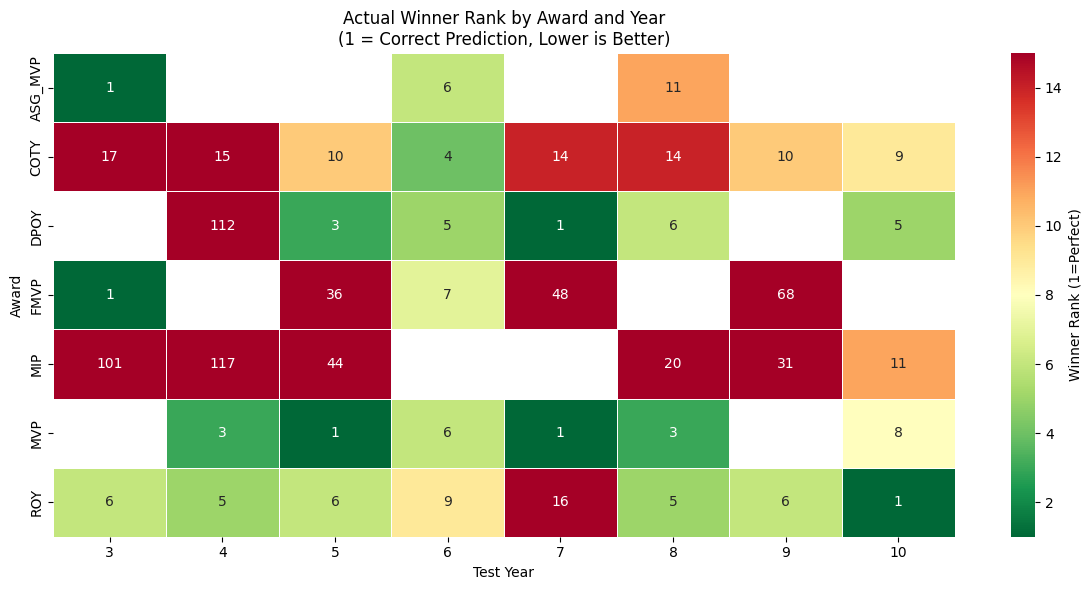

/tmp/ipykernel_56227/3612788369.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top3_acc.values, y=top3_acc.index, palette=colors_bar, ax=ax1)
/tmp/ipykernel_56227/3612788369.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_acc.values, y=top5_acc.index, palette=colors_bar, ax=ax2)


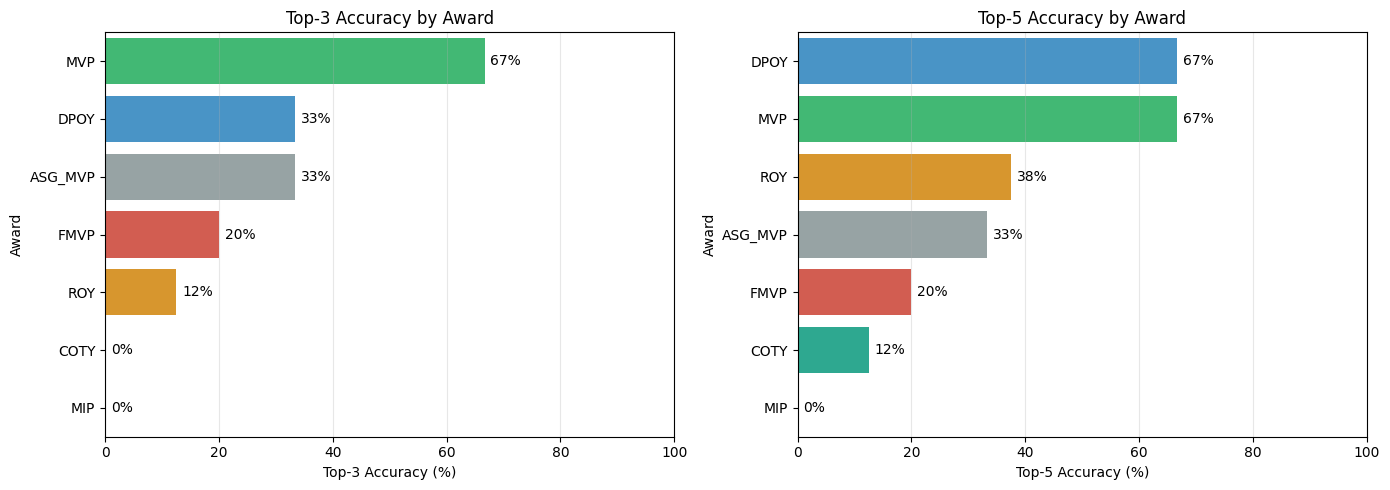

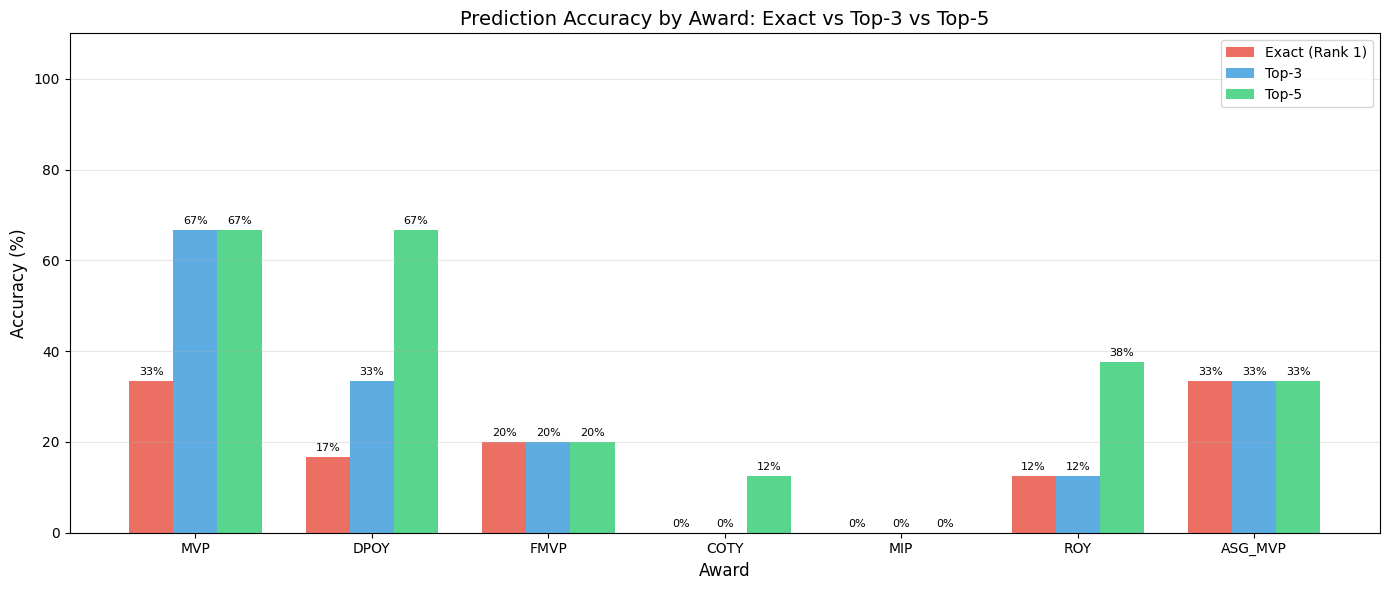

Visualizations saved to presentation_results/


In [13]:
# ===============================================================
# Visualizations - Model Performance
# ===============================================================

colors = {'MVP': '#2ecc71', 'DPOY': '#3498db', 'MIP': '#9b59b6', 
          'FMVP': '#e74c3c', 'ROY': '#f39c12', 'COTY': '#1abc9c', 'ASG_MVP': '#95a5a6'}

summary_plot_data = []
for award_name in ['MVP', 'DPOY', 'MIP', 'FMVP', 'ROY', 'COTY', 'ASG_MVP']:
    results = all_results[award_name]
    if len(results) == 0:
        continue
    for res in results:
        summary_plot_data.append({
            'Award': award_name,
            'Year': res['year'],
            'Winner Rank': res['winner_rank'],
            'Top-3': res['winner_rank'] <= 3,
            'Correct': res['correct']
        })

plot_df = pd.DataFrame(summary_plot_data)

os.makedirs('presentation_results', exist_ok=True)

# --- Plot 1: Winner Rank by Year (Heatmap-style) ---
# Shows how close each prediction was for each award/year combination
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot data for heatmap
pivot_df = plot_df.pivot(index='Award', columns='Year', values='Winner Rank')

# Create heatmap with custom colormap (green=1, yellow=3, red=high)
cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap=cmap, 
            cbar_kws={'label': 'Winner Rank (1=Perfect)'}, 
            linewidths=0.5, ax=ax, vmin=1, vmax=15)
ax.set_title('Actual Winner Rank by Award and Year\n(1 = Correct Prediction, Lower is Better)')
ax.set_xlabel('Test Year')
ax.set_ylabel('Award')
plt.tight_layout()
plt.savefig('presentation_results/winner_rank_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 2: Top-3 and Top-5 Accuracy Comparison ---
# Add Top-5 column to plot_df
plot_df['Top-5'] = plot_df['Winner Rank'] <= 5

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top-3 Accuracy
ax1 = axes[0]
top3_acc = plot_df.groupby('Award')['Top-3'].mean().sort_values(ascending=False) * 100
colors_bar = [colors.get(a, 'gray') for a in top3_acc.index]
sns.barplot(x=top3_acc.values, y=top3_acc.index, palette=colors_bar, ax=ax1)
ax1.set_xlabel('Top-3 Accuracy (%)')
ax1.set_ylabel('Award')
ax1.set_title('Top-3 Accuracy by Award')
ax1.set_xlim(0, 100)
ax1.grid(axis='x', alpha=0.3)
# Add percentage labels
for i, v in enumerate(top3_acc.values):
    ax1.text(v + 1, i, f'{v:.0f}%', va='center', fontsize=10)

# Top-5 Accuracy
ax2 = axes[1]
top5_acc = plot_df.groupby('Award')['Top-5'].mean().sort_values(ascending=False) * 100
colors_bar = [colors.get(a, 'gray') for a in top5_acc.index]
sns.barplot(x=top5_acc.values, y=top5_acc.index, palette=colors_bar, ax=ax2)
ax2.set_xlabel('Top-5 Accuracy (%)')
ax2.set_ylabel('Award')
ax2.set_title('Top-5 Accuracy by Award')
ax2.set_xlim(0, 100)
ax2.grid(axis='x', alpha=0.3)
# Add percentage labels
for i, v in enumerate(top5_acc.values):
    ax2.text(v + 1, i, f'{v:.0f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('presentation_results/top3_top5_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 3: Grouped Bar Chart - Exact, Top-3, Top-5 Accuracy ---
fig, ax = plt.subplots(figsize=(14, 6))

awards_order = ['MVP', 'DPOY', 'FMVP', 'COTY', 'MIP', 'ROY', 'ASG_MVP']
exact_vals = [plot_df[plot_df['Award'] == a]['Correct'].mean() * 100 for a in awards_order if a in plot_df['Award'].values]
top3_vals = [plot_df[plot_df['Award'] == a]['Top-3'].mean() * 100 for a in awards_order if a in plot_df['Award'].values]
top5_vals = [plot_df[plot_df['Award'] == a]['Top-5'].mean() * 100 for a in awards_order if a in plot_df['Award'].values]
awards_present = [a for a in awards_order if a in plot_df['Award'].values]

x = np.arange(len(awards_present))
width = 0.25

bars1 = ax.bar(x - width, exact_vals, width, label='Exact (Rank 1)', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x, top3_vals, width, label='Top-3', color='#3498db', alpha=0.8)
bars3 = ax.bar(x + width, top5_vals, width, label='Top-5', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Award', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Prediction Accuracy by Award: Exact vs Top-3 vs Top-5', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(awards_present)
ax.legend()
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('presentation_results/accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to presentation_results/")

In [14]:
# ===============================================================
# Feature Importance
# ===============================================================

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# build full dataset for feature importance analysis
full_data = build_award_dataset(start_year=2, end_year=max_year)
full_data = add_career_features(full_data)
full_data = add_improvement_features(full_data)
full_data = add_playoff_features(full_data)

# build full ROY dataset
roy_full_data = build_roy_dataset(start_year=1, end_year=max_year)

# build full COTY dataset
coty_full_data = build_coty_dataset(start_year=2, end_year=max_year)

feature_importance_dict = {}

for award_name, config in award_configs.items():
    print(f"\n{award_name}:")
    
    target = config['target']
    features = config['features']
    filter_func = config['filter']
    uses_roy_data = config.get('uses_roy_data', False)
    uses_coty_data = config.get('uses_coty_data', False)
    
    # select appropriate dataset
    if uses_roy_data:
        data_subset = roy_full_data.copy()
    elif uses_coty_data:
        data_subset = coty_full_data.copy()
    else:
        data_subset = full_data.copy()
    
    if filter_func is not None:
        data_subset = data_subset[filter_func(data_subset)]
    
    available_features = [f for f in features if f in data_subset.columns]
    data_subset = data_subset.dropna(subset=available_features)
    
    if len(data_subset) == 0 or data_subset[target].sum() == 0:
        print("  ⚠️ Insufficient data")
        continue
    
    X = data_subset[available_features]
    y = data_subset[target]
    
    model = RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    model.fit(X, y)
    
    # get feature importances
    importances = pd.DataFrame({
        'feature': available_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    feature_importance_dict[award_name] = importances
    
    print(f"  Top 10 features:")
    for _, row in importances.head(10).iterrows():
        print(f"    {row['feature']:<30} {row['importance']:.4f}")

FEATURE IMPORTANCE ANALYSIS

Building dataset for years 2-10
Using T-1 features from years 1-9
Dataset built: (1175, 39)
Career features added
Improvement features added
Playoff features added

Building ROY dataset for years 1-10
Using biometrics, college, and coach data for rookies
ROY Dataset built: (564, 16) (rookies only)

Building COTY dataset for years 2-10
COTY Dataset built: (145, 16)

MVP:
  Top 10 features:
    efficiency_vs_league           0.1883
    efficiency_prev                0.1499
    rating_vs_league               0.1032
    ppg_vs_league                  0.1025
    bpg_prev                       0.0933
    ppg_prev                       0.0922
    player_rating_prev             0.0839
    is_elite_prev                  0.0461
    rpg_prev                       0.0251
    rpg_vs_league                  0.0204

DPOY:
  Top 10 features:
    player_rating_prev             0.1502
    efficiency_prev                0.1471
    spg_prev                       0.1389
    def

/tmp/ipykernel_56227/1706508896.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['importance'].values, y=importances['feature'].values, palette='viridis')


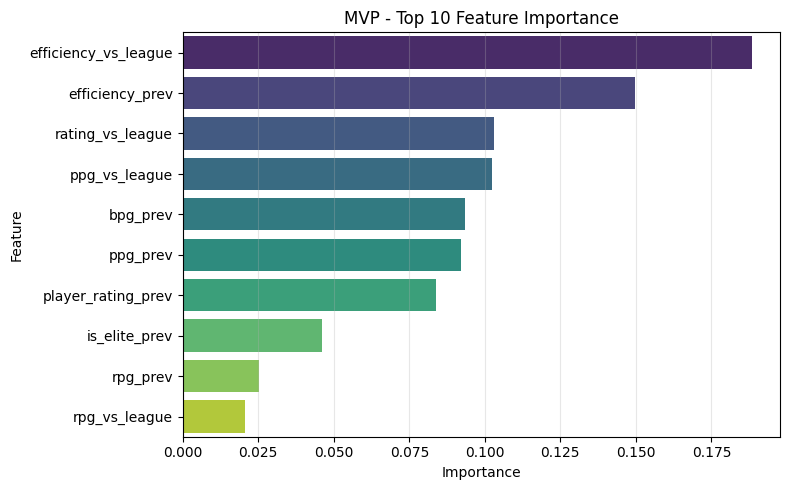

/tmp/ipykernel_56227/1706508896.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['importance'].values, y=importances['feature'].values, palette='viridis')


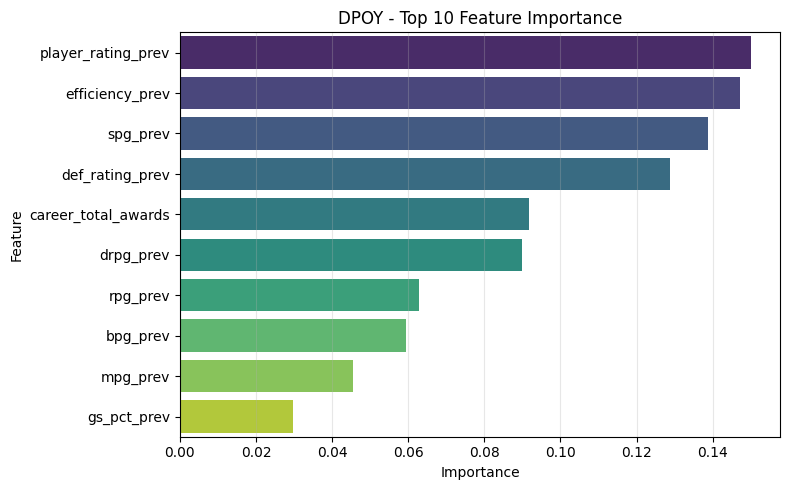

/tmp/ipykernel_56227/1706508896.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['importance'].values, y=importances['feature'].values, palette='viridis')


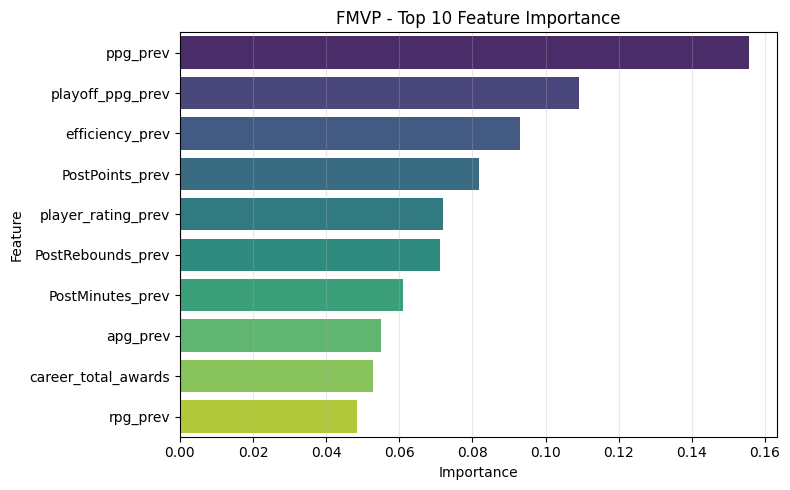

Feature importance plots saved to presentation_results/


In [15]:
# ===============================================================
# Feature Importance Visualization
# ===============================================================

# Show feature importance for key awards (MVP, DPOY, FMVP)
key_awards = ['MVP', 'DPOY', 'FMVP']

for award_name in key_awards:
    if award_name not in feature_importance_dict:
        continue
    
    importances = feature_importance_dict[award_name].head(10)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances['importance'].values, y=importances['feature'].values, palette='viridis')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'{award_name} - Top 10 Feature Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'presentation_results/{award_name.lower()}_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Feature importance plots saved to presentation_results/")